In [130]:
from omegaconf import OmegaConf
import os, sys
import torch
import glob
import pickle
import pandas as pd
import numpy as np
from scipy.stats import norm as scipy_norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pytorch_lightning import Trainer
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from models import UNet, CuboidTransformerModel
from utils.visualization import report_SEVIR_statistics
from models.lightning import SEVIRPLModule

In [2]:
model_name="earthformer_mse_to_nll"
save_dir = "../models/experiments/{}/".format(model_name)
oc_file = os.path.join(save_dir, "cfg.yaml")
checkpoints = os.path.join(save_dir, "checkpoints/")
logs = os.path.join(save_dir, "lightning_logs/")
examples = os.path.join(save_dir, "examples/")
scores = os.path.join(save_dir, "scores/")

In [3]:
oc_from_file = OmegaConf.load(open(oc_file, "r"))
model_cfg = oc_from_file["model"]
loss_cfg = oc_from_file["loss"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
dataset_oc = OmegaConf.to_object(oc_from_file.dataset)
micro_batch_size=1
dm = SEVIRPLModule.get_sevir_datamodule(
        dataset_oc=dataset_oc,
        micro_batch_size=micro_batch_size,
        num_workers=8,)
dm.prepare_data()
dm.setup()

# dataset_oc["dataset_name"] = "storm"
# dm_storm = SEVIRPLModule.get_sevir_datamodule(
#         dataset_oc=dataset_oc,
#         micro_batch_size=micro_batch_size,
#         num_workers=8,)
# dm_storm.prepare_data()
# dm_storm.setup()

# dataset_oc["dataset_name"] = "random"
# dm_random = SEVIRPLModule.get_sevir_datamodule(
#         dataset_oc=dataset_oc,
#         micro_batch_size=micro_batch_size,
#         num_workers=8,)
# dm_random.prepare_data()
# dm_random.setup()

In [5]:
# if model_cfg["name"] == "earthformer":
#     model = CuboidTransformerModel(
#         input_shape=model_cfg["input_shape"],
#         target_shape=model_cfg["target_shape"],
#         base_units=model_cfg["base_units"],
#         block_units=model_cfg["block_units"],
#         scale_alpha=model_cfg["scale_alpha"],
#         enc_depth=model_cfg["enc_depth"],
#         dec_depth=model_cfg["dec_depth"],
#         enc_use_inter_ffn=model_cfg["enc_use_inter_ffn"],
#         dec_use_inter_ffn=model_cfg["dec_use_inter_ffn"],
#         dec_hierarchical_pos_embed=model_cfg["dec_hierarchical_pos_embed"],
#         downsample=model_cfg["downsample"],
#         downsample_type=model_cfg["downsample_type"],
#         enc_attn_patterns=enc_attn_patterns,
#         dec_self_attn_patterns=dec_self_attn_patterns,
#         dec_cross_attn_patterns=dec_cross_attn_patterns,
#         dec_cross_last_n_frames=model_cfg["dec_cross_last_n_frames"],
#         dec_use_first_self_attn=model_cfg["dec_use_first_self_attn"],
#         num_heads=model_cfg["num_heads"],
#         attn_drop=model_cfg["attn_drop"],
#         proj_drop=model_cfg["proj_drop"],
#         ffn_drop=model_cfg["ffn_drop"],
#         upsample_type=model_cfg["upsample_type"],
#         ffn_activation=model_cfg["ffn_activation"],
#         gated_ffn=model_cfg["gated_ffn"],
#         norm_layer=model_cfg["norm_layer"],
#         # global vectors
#         num_global_vectors=model_cfg["num_global_vectors"],
#         use_dec_self_global=model_cfg["use_dec_self_global"],
#         dec_self_update_global=model_cfg["dec_self_update_global"],
#         use_dec_cross_global=model_cfg["use_dec_cross_global"],
#         use_global_vector_ffn=model_cfg["use_global_vector_ffn"],
#         use_global_self_attn=model_cfg["use_global_self_attn"],
#         separate_global_qkv=model_cfg["separate_global_qkv"],
#         global_dim_ratio=model_cfg["global_dim_ratio"],
#         # initial_downsample
#         initial_downsample_type=model_cfg["initial_downsample_type"],
#         initial_downsample_activation=model_cfg["initial_downsample_activation"],
#         # initial_downsample_type=="stack_conv"
#         initial_downsample_stack_conv_num_layers=model_cfg["initial_downsample_stack_conv_num_layers"],
#         initial_downsample_stack_conv_dim_list=model_cfg["initial_downsample_stack_conv_dim_list"],
#         initial_downsample_stack_conv_downscale_list=model_cfg["initial_downsample_stack_conv_downscale_list"],
#         initial_downsample_stack_conv_num_conv_list=model_cfg["initial_downsample_stack_conv_num_conv_list"],
#         # misc
#         padding_type=model_cfg["padding_type"],
#         z_init_method=model_cfg["z_init_method"],
#         checkpoint_level=model_cfg["checkpoint_level"],
#         pos_embed_type=model_cfg["pos_embed_type"],
#         use_relative_pos=model_cfg["use_relative_pos"],
#         self_attn_use_final_proj=model_cfg["self_attn_use_final_proj"],
#         # initialization
#         attn_linear_init_mode=model_cfg["attn_linear_init_mode"],
#         ffn_linear_init_mode=model_cfg["ffn_linear_init_mode"],
#         conv_init_mode=model_cfg["conv_init_mode"],
#         down_up_linear_init_mode=model_cfg["down_up_linear_init_mode"],
#         norm_init_mode=model_cfg["norm_init_mode"],
#         edl = loss_cfg["edl"],
#         edl_act = loss_cfg["edl_act"],
#     ).to(device)
# elif model_cfg["name"] == "unet":
#     model = UNet(
#         input_shape=model_cfg["input_shape"],
#         target_shape=model_cfg["target_shape"],
#         enc_nodes=model_cfg["enc_nodes"],
#         center=model_cfg["center"],
#         dec_nodes=model_cfg["dec_nodes"],
#         activation=model_cfg["activation"],
#         edl = loss_cfg["edl"],
#         edl_act = loss_cfg["edl_act"],
#     ).to(device)

In [6]:
# model.load_state_dict(torch.load(os.path.join(checkpoints, "_sevir.pt")))

<All keys matched successfully>

In [5]:
ckpts = glob.glob(checkpoints + '*.ckpt')
print(ckpts)
curr_ckpt = ckpts[0]
print(curr_ckpt)

['../models/experiments/earthformer_mse_to_nll/checkpoints/last.ckpt', '../models/experiments/earthformer_mse_to_nll/checkpoints/model-epoch=019.ckpt']
../models/experiments/earthformer_mse_to_nll/checkpoints/last.ckpt


In [6]:
total_num_steps = SEVIRPLModule.get_total_num_steps(
    epoch=oc_from_file.optim.max_epochs,
    num_samples=dm.num_train_samples,
    total_batch_size=oc_from_file.optim.total_batch_size,
)
pl_module = SEVIRPLModule.load_from_checkpoint(curr_ckpt, total_num_steps=total_num_steps, save_dir=model_name, oc_file=oc_file)
accumulate_grad_batches = oc_from_file.optim.total_batch_size // (oc_from_file.optim.micro_batch_size * 1)
trainer_kwargs = pl_module.set_trainer_kwargs(
    devices= 1,
    accumulate_grad_batches=accumulate_grad_batches,
)
trainer_kwargs['strategy'] = 'auto'
if len(trainer_kwargs['logger']) == 3:
    trainer_kwargs['logger'].pop()
trainer = Trainer(**trainer_kwargs)

/home/idies/workspace/Storage/akhot2/persistent/earthformer/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
# trainer.test(model=pl_module, datamodule=dm_storm)

In [ ]:
# trainer.test(model=pl_module, datamodule=dm_random)

In [39]:
result_files = glob.glob(scores + '*')
result_files.sort()

combined_metrics = {}

for file in result_files:
    with open(file, 'rb') as f:
        data = pickle.load(f)
        for k, v in data.items():
            if isinstance(v, dict):
                for kk, vv in v.items():
                    key = str(k) + '_' + str(kk)
                    if key not in combined_metrics:
                        combined_metrics[key] = []
                    combined_metrics[key].append(vv)
            else:
                key = str(k)
                if key not in combined_metrics:
                    combined_metrics[key] = []
                combined_metrics[key].append(v.cpu())

In [ ]:
# Number of epochs
epochs = range(1, len(next(iter(combined_metrics.values()))) + 1)

# Create subplots
fig, axs = plt.subplots(len(combined_metrics), 1, figsize=(8, 8 * len(combined_metrics)))

# Plot each metric
for i, (metric, values) in enumerate(combined_metrics.items()):
    axs[i].plot(epochs, values, marker='o', label=metric)
    axs[i].set_xlabel('epoch', fontsize=24)
    axs[i].set_ylabel(metric, fontsize=24)
    axs[i].tick_params(axis='both', which='major', labelsize=24)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [50]:
log_files_train = glob.glob(os.path.join(logs, "version_1/*.csv"))[0]
log_files_val = glob.glob(os.path.join(logs, "version_3/*.csv"))[0]

In [ ]:
pd.read_csv(log_files_train)

In [46]:
example_files = glob.glob(examples + '*')
example_files.sort()
print(example_files)

['../models/experiments/unet/examples/test_epoch_0_data_0.png', '../models/experiments/unet/examples/train_epoch_0_data_0.png', '../models/experiments/unet/examples/train_epoch_1_data_0.png', '../models/experiments/unet/examples/train_epoch_2_data_0.png', '../models/experiments/unet/examples/val_epoch_0_data_80.png', '../models/experiments/unet/examples/val_epoch_1_data_80.png', '../models/experiments/unet/examples/val_epoch_2_data_80.png']


../models/experiments/unet/examples/val_epoch_2_data_80.png


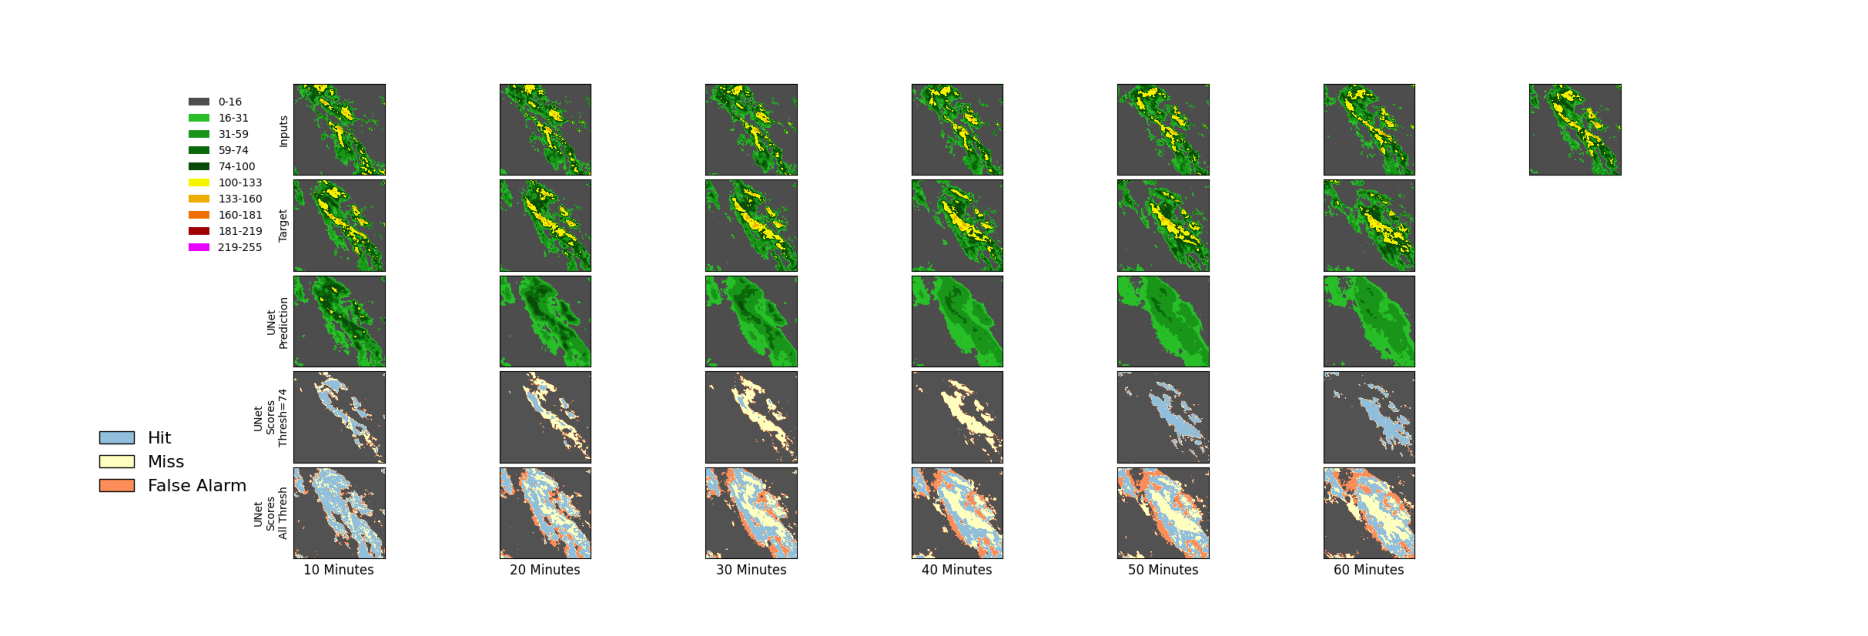

In [47]:
file = example_files[-1]
print(file)
img = mpimg.imread(file)
plt.figure(figsize=(24, 8))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
test_loader = dm.test_dataloader()

In [82]:
import sys
sys.path.append('../') # add sevir module to path
from utils.visualization.sevir_cmap import get_cmap
# Get colormaps for encoded types
cmap_dict = lambda s: {'cmap': get_cmap(s, encoded=True)[0],
                           'norm': get_cmap(s, encoded=True)[1],
                           'vmin': get_cmap(s, encoded=True)[2],
                           'vmax': get_cmap(s, encoded=True)[3]}

In [59]:
x.max()

tensor(0.9294, device='cuda:0')

In [65]:
print(vil_cmap)

In [108]:
import matplotlib.animation as animation

def generate_video_many(inp, target, output, mse, unc):
    frames = []
    fig,axs = plt.subplots(1,5,figsize=(14,5))
        
    for j in range(5):
        axs[j].get_xaxis().set_visible(False)
        axs[j].get_yaxis().set_visible(False)
    
    for i in range(target.shape[1]):
        frame_idx = i
        f4 = axs[0].imshow(inp[0, frame_idx, :, :, 0],**cmap_dict('vil'))
        axs[0].set_title('Input')
        f0 = axs[1].imshow(target[0, frame_idx, :, :, 0],**cmap_dict('vil'))
        axs[1].set_title('Target')
        f1 = axs[2].imshow(output[0, frame_idx, :, :, 0],**cmap_dict('vil'))
        axs[2].set_title('Output')
        f2 = axs[3].imshow(mse[0, frame_idx, :, :, 0])
        axs[3].set_title('Error')
        f3 = axs[4].imshow(unc[0, frame_idx, :, :, 0])
        axs[4].set_title('EDL Uncertainty')
        
        frames.append([f4, f0, f1, f2, f3])
        
    
    ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat_delay=2000)
    ani.save('movie.gif', writer='pillow')
    plt.show()

In [102]:
batch.keys()

dict_keys(['vil'])

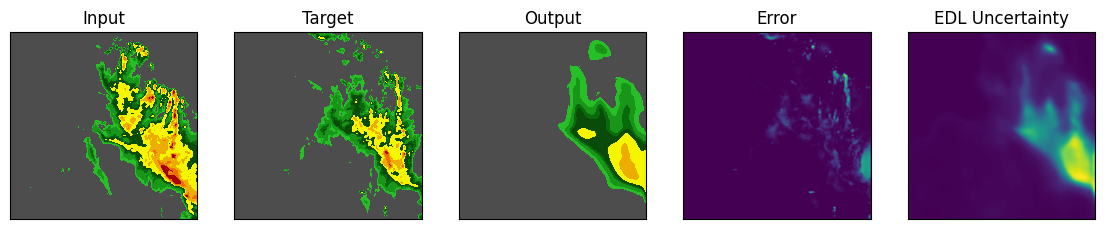

mae 0.029452108
mse 0.0043818504


In [109]:
for batch_idx, batch in enumerate(test_loader):
    data_seq = batch['vil'].contiguous()
    x = data_seq[pl_module.in_slice].to(device)
    y = data_seq[pl_module.out_slice].to(device)
    micro_batch_size = x.shape[pl_module.layout.find("N")]
    data_idx = int(batch_idx * micro_batch_size)
    if data_idx != 240:
        continue
    y_hat, _, _, edl_params = pl_module(x, y)
    for i in range(3):
        edl_params[i] = edl_params[i].detach().float().cpu().numpy()
        
    v, alpha, beta = edl_params
    aleatoric = beta/(alpha - 1)
    epistemic = aleatoric/v
    
    generate_video_many(x.detach().float().cpu().numpy() * 255 , 
                        y.detach().float().cpu().numpy()* 255, 
                        y_hat.detach().float().cpu().numpy()* 255, 
                        ((y - y_hat)**2).detach().float().cpu().numpy(), epistemic)
    
    if pl_module.oc.trainer.precision == 16:
        y_hat = y_hat.float()
    step_mse = pl_module.test_mse(y_hat, y)
    step_mae = pl_module.test_mae(y_hat, y)
    print('mae', step_mae.detach().cpu().numpy())
    print('mse', step_mse.detach().cpu().numpy())
    break

In [98]:
epistemic.shape

(1, 12, 384, 384, 1)

In [94]:
for batch_idx, batch in enumerate(test_loader):
    data_seq = batch['vil'].contiguous()
    x = data_seq[pl_module.in_slice].to(device)
    y = data_seq[pl_module.out_slice].to(device)
    micro_batch_size = x.shape[pl_module.layout.find("N")]
    data_idx = int(batch_idx * micro_batch_size)
    if data_idx != 160:
        continue
    y_hat, _, _, edl_params = pl_module(x, y)
    pl_module.save_vis_step_end(
        data_idx=data_idx,
        in_seq=x,
        target_seq=y,
        pred_seq=y_hat,
        edl_params=edl_params,
        mode="test"
    )
    if pl_module.oc.trainer.precision == 16:
        y_hat = y_hat.float()
    step_mse = pl_module.test_mse(y_hat, y)
    step_mae = pl_module.test_mae(y_hat, y)
    print('mae', step_mae.detach().cpu().numpy())
    print('mse', step_mse.detach().cpu().numpy())
    break

mae 0.032418825
mse 0.0038275477


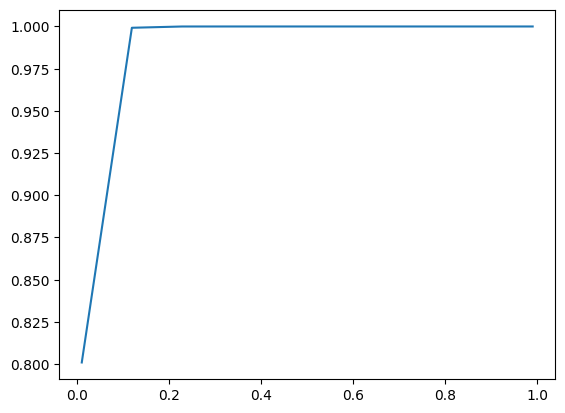

In [20]:
prob = np.linspace(0.01, 0.99, 10)
freq = []
for p in prob:
    count = 0
    numels = 0
        
    for batch_idx, batch in enumerate(test_loader):
        if batch_idx == 1000:
            break
        data_seq = batch['vil'].contiguous()
        x = data_seq[pl_module.in_slice].to(device)
        y = data_seq[pl_module.out_slice].to(device)
        micro_batch_size = x.shape[pl_module.layout.find("N")]
        data_idx = int(batch_idx * micro_batch_size)
        y_hat, _, _, edl_params = pl_module(x, y)
        if pl_module.oc.trainer.precision == 16:
            y_hat = y_hat.float()
        
        x = x.detach().float().cpu()
        y = y.detach().float().cpu()
        y_hat = y_hat.detach().float().cpu()
        for i in range(3):
            edl_params[i] = edl_params[i].detach().float().cpu()
        v, alpha, beta = edl_params
        aleatoric = beta/(alpha - 1)
        epistemic = aleatoric/v

        interval = scipy_norm.interval(p, loc=y_hat, scale=epistemic.sqrt())

        count += ((y.numpy() >= interval[0]) & (y.numpy() <= interval[1])).sum()

        numels += y.numel()
        # print('p: {}, {} / {} = {}'.format(p, count, numels, np.true_divide(count, numels)))
    
    freq.append(np.true_divide(count, numels))

plt.plot(prob, freq)

earthformer_mse
['../models/experiments/earthformer_mse/checkpoints/model-epoch=033.ckpt', '../models/experiments/earthformer_mse/checkpoints/last.ckpt']
../models/experiments/earthformer_mse/checkpoints/last.ckpt
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
earthformer_mse_late
['../models/experiments/earthformer_mse_late/checkpoints/model-epoch=037.ckpt', '../models/experiments/earthformer_mse_late/checkpoints/last.ckpt']
../models/experiments/earthformer_mse_late/checkpoints/last.ckpt
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
earthformer_mse_to_nll
['../models/experiments/earthformer_mse_to_nll/checkpoints/last.ckpt', '../models/experiments/earthformer_mse_to_nll/checkpoints/model-epoch=019.ckpt']
../models/experiments/earthformer_mse_to_nll/checkpoints/model-epoch=019.ckpt
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200
0
100
200

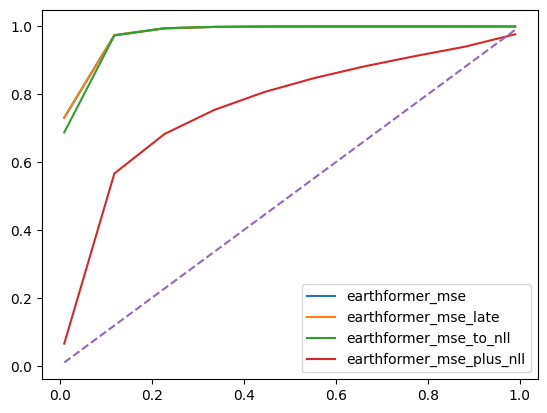

In [131]:
model_names = ["earthformer_mse", "earthformer_mse_late", "earthformer_mse_to_nll", "earthformer_mse_plus_nll"]
prob = np.linspace(0.01, 0.99, 10)

freqs = []
for modelname in model_names:
    print(modelname)
    save_dir = "../models/experiments/{}/".format(modelname)
    oc_file = os.path.join(save_dir, "cfg.yaml")
    checkpoints = os.path.join(save_dir, "checkpoints/")

    oc_from_file = OmegaConf.load(open(oc_file, "r"))

    dataset_oc = OmegaConf.to_object(oc_from_file.dataset)
    micro_batch_size=1
    dm = SEVIRPLModule.get_sevir_datamodule(
            dataset_oc=dataset_oc,
            micro_batch_size=micro_batch_size,
            num_workers=8,)
    dm.prepare_data()
    dm.setup()

    total_num_steps = SEVIRPLModule.get_total_num_steps(
        epoch=oc_from_file.optim.max_epochs,
        num_samples=dm.num_train_samples,
        total_batch_size=oc_from_file.optim.total_batch_size,
    )
    
    ckpts = glob.glob(checkpoints + '*.ckpt')
    print(ckpts)
    curr_ckpt = ckpts[1]
    print(curr_ckpt)

    pl_module = SEVIRPLModule.load_from_checkpoint(curr_ckpt, total_num_steps=total_num_steps, save_dir=model_name, oc_file=oc_file)


    test_loader = dm.test_dataloader()
    
    freq = []
    for p in prob:
        count = 0
        numels = 0

        for batch_idx, batch in enumerate(test_loader):
            if batch_idx % 100 == 0:
                print(batch_idx)
            if batch_idx == 200:
                break
            data_seq = batch['vil'].contiguous()
            x = data_seq[pl_module.in_slice].to(device)
            y = data_seq[pl_module.out_slice].to(device)
            micro_batch_size = x.shape[pl_module.layout.find("N")]
            data_idx = int(batch_idx * micro_batch_size)
            y_hat, _, _, edl_params = pl_module(x, y)
            if pl_module.oc.trainer.precision == 16:
                y_hat = y_hat.float()

            x = x.detach().float().cpu()
            y = y.detach().float().cpu()
            y_hat = y_hat.detach().float().cpu()
            for i in range(3):
                edl_params[i] = edl_params[i].detach().float().cpu()
            v, alpha, beta = edl_params
            aleatoric = beta/(alpha - 1)
            epistemic = aleatoric/v

            interval = scipy_norm.interval(p, loc=y_hat, scale=epistemic.sqrt())

            count += ((y.numpy() >= interval[0]) & (y.numpy() <= interval[1])).sum()

            numels += y.numel()
            # print('p: {}, {} / {} = {}'.format(p, count, numels, np.true_divide(count, numels)))

        freq.append(np.true_divide(count, numels))
    freqs.append(freq)
    plt.plot(prob, freq, label=modelname)
plt.plot(prob, prob, '--')
plt.legend()
plt.show()

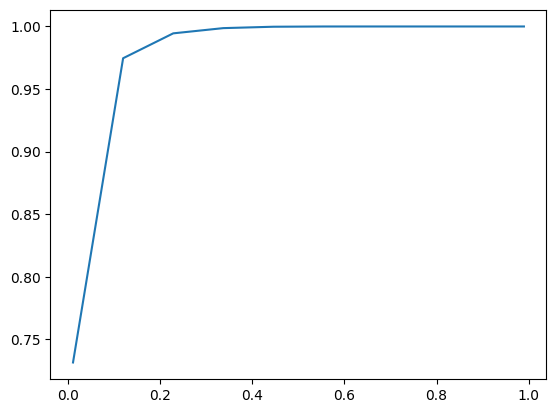

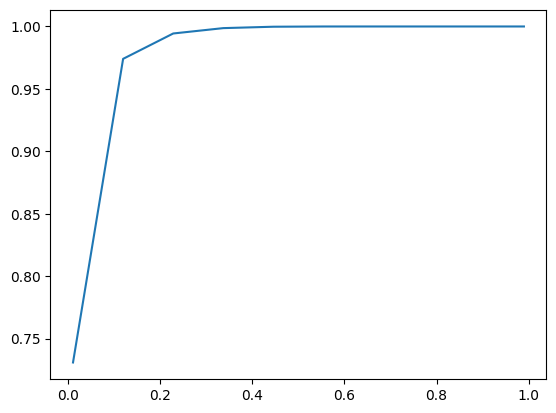

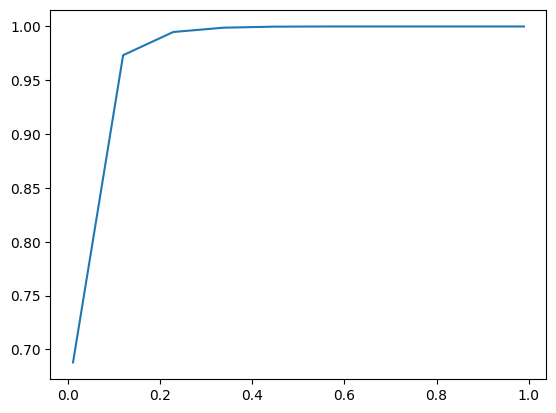

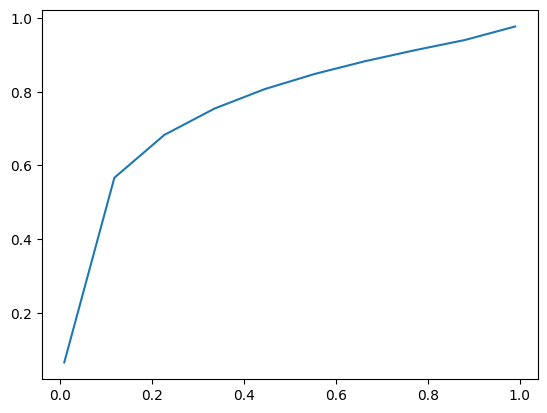

In [133]:
for i in range(4):
    plt.plot(prob, freqs[i])
    plt.show()

In [152]:
# Define the edges of the bins
x_edges = np.linspace(0, 0.2, 100) #unc
y_edges = np.linspace(0, 1, 100) #mse
hist = np.zeros((len(x_edges) - 1, len(y_edges) - 1))

# Function to update the histogram
def update_histogram(data_chunk_0, data_chunk_1, hist, x_edges, y_edges):
    hist_chunk, _, _ = np.histogram2d(data_chunk_0, data_chunk_1, bins=[x_edges, y_edges])
    hist += hist_chunk

In [153]:
from matplotlib.colors import LogNorm

0
mse tensor(1.5667e-17) tensor(0.3692)
unc tensor(9.6591e-06) tensor(0.0497)
mse tensor(2.8103e-16) tensor(0.7162)
unc tensor(7.7641e-06) tensor(0.0232)
mse tensor(4.3910e-18) tensor(0.7846)
unc tensor(7.7716e-06) tensor(0.0897)
mse tensor(5.5511e-17) tensor(0.8765)
unc tensor(1.7173e-05) tensor(0.6632)
mse tensor(7.8063e-18) tensor(0.6639)
unc tensor(1.9585e-05) tensor(0.3465)
mse tensor(3.4694e-18) tensor(0.8061)
unc tensor(1.5388e-05) tensor(0.1897)
mse tensor(0.) tensor(0.9201)
unc tensor(1.2497e-05) tensor(0.2720)
mse tensor(0.) tensor(0.8492)
unc tensor(1.4908e-05) tensor(0.2078)
mse tensor(2.1684e-19) tensor(0.8129)
unc tensor(1.7007e-05) tensor(0.6908)
mse tensor(8.6736e-19) tensor(0.9563)
unc tensor(1.0115e-05) tensor(1.3976)
mse tensor(0.) tensor(0.7459)
unc tensor(1.1961e-05) tensor(0.7016)
mse tensor(0.) tensor(0.9417)
unc tensor(9.5771e-06) tensor(0.5815)
mse tensor(5.4210e-20) tensor(0.9130)
unc tensor(1.8124e-05) tensor(2.1771)
mse tensor(7.8063e-18) tensor(0.7720)
unc 

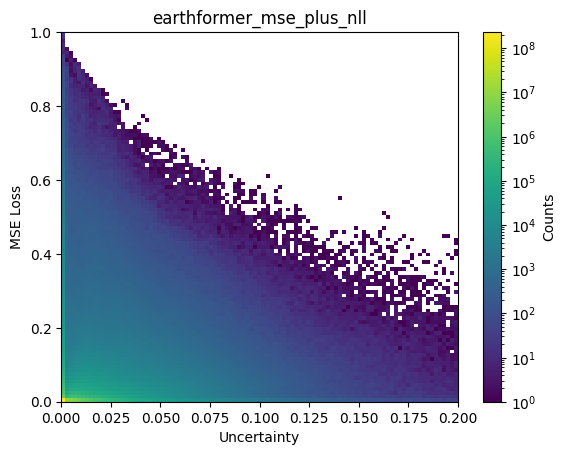

In [157]:
model_names = ["earthformer_mse_plus_nll"]

for modelname in model_names:
    
    save_dir = "../models/experiments/{}/".format(modelname)
    oc_file = os.path.join(save_dir, "cfg.yaml")
    oc_from_file = OmegaConf.load(open(oc_file, "r"))

    dataset_oc = OmegaConf.to_object(oc_from_file.dataset)
    micro_batch_size=1
    dm = SEVIRPLModule.get_sevir_datamodule(
            dataset_oc=dataset_oc,
            micro_batch_size=micro_batch_size,
            num_workers=8,)
    dm.prepare_data()
    dm.setup()

    total_num_steps = SEVIRPLModule.get_total_num_steps(
        epoch=oc_from_file.optim.max_epochs,
        num_samples=dm.num_train_samples,
        total_batch_size=oc_from_file.optim.total_batch_size,
    )
    pl_module = SEVIRPLModule.load_from_checkpoint(curr_ckpt, total_num_steps=total_num_steps, save_dir=model_name, oc_file=oc_file)


    test_loader = dm.test_dataloader()
    
    for batch_idx, batch in enumerate(test_loader):
        if batch_idx % 100 == 0:
            print(batch_idx)
        if batch_idx == 50:
            break
        data_seq = batch['vil'].contiguous()
        x = data_seq[pl_module.in_slice].to(device)
        y = data_seq[pl_module.out_slice].to(device)
        micro_batch_size = x.shape[pl_module.layout.find("N")]
        data_idx = int(batch_idx * micro_batch_size)
        y_hat, _, _, edl_params = pl_module(x, y)
        if pl_module.oc.trainer.precision == 16:
            y_hat = y_hat.float()

        mse = (y - y_hat)**2
        mse = mse.detach().float().cpu()

        x = x.detach().float().cpu()
        y = y.detach().float().cpu()
        y_hat = y_hat.detach().float().cpu()
        for i in range(3):
            edl_params[i] = edl_params[i].detach().float().cpu()
        v, alpha, beta = edl_params
        aleatoric = beta/(alpha - 1)
        epistemic = aleatoric/v
        
        mse = (y - y_hat)**2
                
        print("mse", mse.min(), mse.max())
        print("unc", epistemic.min(), epistemic.max())
        
        update_histogram(epistemic.flatten(), mse.flatten(), hist, x_edges, y_edges)
            

    # Plot the histogram
    plt.imshow(hist.T, origin='lower', aspect='auto', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], norm=LogNorm())
    plt.colorbar(label='Counts')
    plt.xlabel('Uncertainty')
    plt.ylabel('MSE Loss')
    plt.title(modelname)
    plt.show()